# Projet: détecter les Fakes tweets

Twitter est devenu un canal de communication important en cas d’urgence.
L’omniprésence des smartphones permet aux gens d’annoncer une urgence qu’ils observent en temps réel. Pour cette raison, de plus en plus d’agences sont intéressées par la surveillance programmatique de Twitter (c’est-à-dire les organisations de secours en cas de catastrophe et les agences de presse).
Mais, il n’est pas toujours clair si les mots d’une personne annoncent réellement une catastrophe.  
  
**Objectifs**  
- Traitement des données "text". Le prprocessing est important
- Création d'un algorythme de deep learning


## Importations des bibliothèques


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import string

import tensorflow as tf
import matplotlib.pyplot as plt
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

from keras.models import Sequential
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from keras.optimizers import *


import json

In [3]:
data = pd.read_csv("tweet_train.csv")

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Il n'y a pas de valeurs manquantes

## Analyses des données

In [7]:
data["target"].value_counts(normalize = True) # connaître la proportion de fake news ou non du dataset

0    0.57034
1    0.42966
Name: target, dtype: float64

1 correspond à des fake tweet. 0 correspond aux tweets réels. Il y a 57% de tweets réels et 43% de fake tweets

In [8]:
data["text"].str.len() # permet de connaitre le nombre de caractère de chaques tweets

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 7613, dtype: int64

Text(0.5, 1.0, 'real tweets')

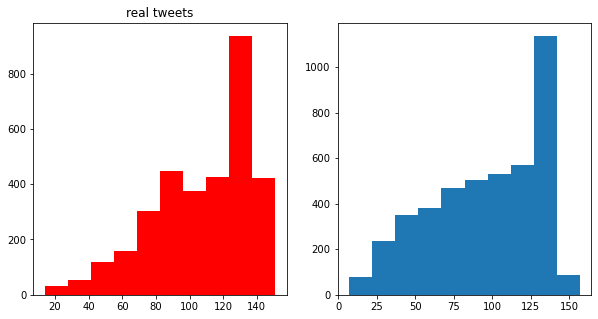

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(data[data["target"]==1]["text"].str.len(), color = "red")
ax1.set_title('fake tweets')

ax2.hist(data[data["target"]==0]["text"].str.len())
ax1.set_title('real tweets')


Il n'y a pas de différence dans le nombre de caractère entre un vrai et un faux tweet

## Preprocessing

On garde que id, text et target

In [10]:
df = data[["id", "text", "target"]]
df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
def clean_text(text):
    """Mettre en minuscule, enlever les crochets, enlever https, enlever la ponctuation et enlever les nombres"""
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
df["text_clean"] = df["text"].apply(lambda x: clean_text(x))
df.head()
# Appliquer la fonction clean_text

<ipython-input-12-569759ae6f0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = df["text"].apply(lambda x: clean_text(x))


,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [13]:
nlp = en_core_web_sm.load() # chargement d'un modèle de spacy

In [14]:
def lemma(text):
    """ Lematisation, on enlève aussi les STOP_WORDS"""
    text = " ".join([token.lemma_ for token in nlp(text) if token.lemma_ not in STOP_WORDS])
    return text

In [15]:
df["text_clean"] = df["text_clean"].apply(lambda x: lemma(x))
df.head()
# Application da la fonction lemma

<ipython-input-15-0dfa8b193204>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = df["text_clean"].apply(lambda x: lemma(x))


,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() 

In [17]:
tokenizer.fit_on_texts(df["text_clean"])
df["text_encoded"] = tokenizer.texts_to_sequences(df["text_clean"])
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]

In [18]:
df.head()

,id,text,target,text_clean,text_encoded,len_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3483, 406, 165, 1327, 1638]",5
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[117, 4, 156, 512, 5191, 5192, 936]",7
2,5,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1328, 435, 1639, 317, 5193, 290, 179, 1639, 3...",11
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[9, 2221, 68, 179, 276, 36]",6
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[277, 172, 124, 5194, 1640, 166, 68, 2222, 105]",9


In [19]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")

In [20]:
reviews_pad

array([[3483,  406,  165, ...,    0,    0,    0],
       [ 117,    4,  156, ...,    0,    0,    0],
       [1328,  435, 1639, ...,    0,    0,    0],
       ...,
       [   7,  387, 1205, ...,    0,    0,    0],
       [  25,  717, 2473, ...,    0,    0,    0],
       [ 107,   29,  348, ...,    0,    0,    0]])

In [33]:
reviews_pad.shape

(7611, 21)

In [21]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, df["target"].values)) # Création de tensorflow dataset

In [32]:
full_ds


<TensorSliceDataset shapes: ((21,), ()), types: (tf.int32, tf.int64)>

In [22]:
# Train Test Split
TAKE_SIZE = int(0.7*df.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(16)

In [35]:
for review, target in train_data.take(1):
    print(review, target)

tf.Tensor(
[[ 1716  2343   595  2858  2344  1715   148   368     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  128  1914   198   697   693  2068  8666   847    51    53   697  8667
      0     0     0     0     0     0     0     0     0]
 [ 1350  1010  1144  1912  5564   294     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [ 1110  4381 10330 10331   435   275     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  753  1400   371  3551    96    38  9891  9892  3025   823     0     0
      0     0     0     0     0     0     0     0     0]
 [ 5934  1667   668  5935     7  5936  2843  5937     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  117    70   732  1315  3936     4     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [  517   397  7169   517    42    87     0     0     0     0     0     

In [23]:
train=reviews_pad[:df.shape[0]]
test=reviews_pad[df.shape[0]:]

In [24]:
train

array([[3483,  406,  165, ...,    0,    0,    0],
       [ 117,    4,  156, ...,    0,    0,    0],
       [1328,  435, 1639, ...,    0,    0,    0],
       ...,
       [   7,  387, 1205, ...,    0,    0,    0],
       [  25,  717, 2473, ...,    0,    0,    0],
       [ 107,   29,  348, ...,    0,    0,    0]])

In [25]:
test

array([], shape=(0, 21), dtype=int32)

In [26]:
#for text, target in train_data.take(1):
  #print(text, target)

In [27]:
vocab_size = len(tokenizer.word_index)
vocab_size

14297

In [28]:
# Création d'un modèle de deep learning

model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64,input_shape=[test.shape[1]]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            915072    
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                86080     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,005,377
Trainable params: 1,005,377
Non-trainable params: 0
_________________________________________________________________


In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [42]:
X_train,X_test,y_train,y_test=train_test_split(train,df['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6469, 21)
Shape of Validation  (1142, 21)


In [37]:
history=model.fit(train_data,batch_size=4,epochs=30,validation_data=test_data,verbose=2)

Epoch 1/30
333/333 - 7s - loss: 0.5521 - accuracy: 0.8350 - val_loss: 0.6383 - val_accuracy: 0.6502
Epoch 2/30
333/333 - 7s - loss: 0.5340 - accuracy: 0.8434 - val_loss: 0.6309 - val_accuracy: 0.6546
Epoch 3/30
333/333 - 7s - loss: 0.5148 - accuracy: 0.8524 - val_loss: 0.6257 - val_accuracy: 0.6651
Epoch 4/30
333/333 - 7s - loss: 0.4949 - accuracy: 0.8577 - val_loss: 0.6178 - val_accuracy: 0.6620
Epoch 5/30
333/333 - 7s - loss: 0.4743 - accuracy: 0.8633 - val_loss: 0.6105 - val_accuracy: 0.6624
Epoch 6/30
333/333 - 8s - loss: 0.4541 - accuracy: 0.8697 - val_loss: 0.6050 - val_accuracy: 0.6729
Epoch 7/30
333/333 - 7s - loss: 0.4339 - accuracy: 0.8742 - val_loss: 0.5996 - val_accuracy: 0.6843
Epoch 8/30
333/333 - 7s - loss: 0.4142 - accuracy: 0.8825 - val_loss: 0.5957 - val_accuracy: 0.6874
Epoch 9/30
333/333 - 7s - loss: 0.3953 - accuracy: 0.8879 - val_loss: 0.5878 - val_accuracy: 0.6918
Epoch 10/30
333/333 - 8s - loss: 0.3766 - accuracy: 0.8919 - val_loss: 0.5826 - val_accuracy: 0.6975

In [38]:
model.save("FakeTweet_model_2.h5")

In [39]:
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open("FakeTweet_history_2.json", 'w'))

In [40]:
model = tf.keras.models.load_model("FakeTweet_model_2.h5")

## Test du model

On récupère le csv_test du projet fake news. On va réaliser des predictions sur les tweets(faux ou vrai) et comparer la prédiction avec la target. 

In [43]:
predictions = model.predict(X_test)

In [44]:
predictions

array([[0.33219686],
       [0.25953227],
       [0.19684938],
       ...,
       [0.07439739],
       [0.1318562 ],
       [0.99148774]], dtype=float32)

In [45]:
pred_label = tf.argmax(predictions, axis=-1).numpy()

In [46]:
pred_label

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
len(pred_label)

1142

In [48]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, pred_label)
print(cf_matrix)

[[646   0]
 [496   0]]


**Conclusion**  
  
Le preprocessing à permit de transformer les tweets en tensor tensoflow.  
Le modèle de deep learning est construit avec plusieurs couches de neurones.  

Après entrainement du modèle on arrive à une accuracy de 95% avec les données train et 72% avec les données test.  
**Cependant** la matrice de confusion montre que notre modèle n'arrive pas a prédire un **faux tweet**. Inversement le modèle ne prédit aucun faux tweet alors qu'il est vraie. On peut conclure : 
- Le modèle n'arrive pas à apprendre avec mes données et il prédit  que tout les tweets sont vrais.  
- Problème d'over fiting  
  
**Perspectives**  
Utilisation de bert ? 
Retravailler le modèle (les couches de neurones)